# Swissroll Example

### Imports

In [1]:
from sklearn import datasets, neighbors, preprocessing
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import rcParams

# local imports
from os import chdir
chdir("../")

from lllvm import LL_LVM

chdir("demo")

# Plotting configuration
%matplotlib inline
rcParams['figure.figsize'] = (10,8)
sns.set()

# Simulation Data

In [2]:
data = datasets.make_swiss_roll(400, 0.01)
#x = preprocessing.normalize(data[0])
x = data[0] / np.sum(data[0],0)
x = x.T
t_true = data[1].T
Dy,N = x.shape
Dt = 1

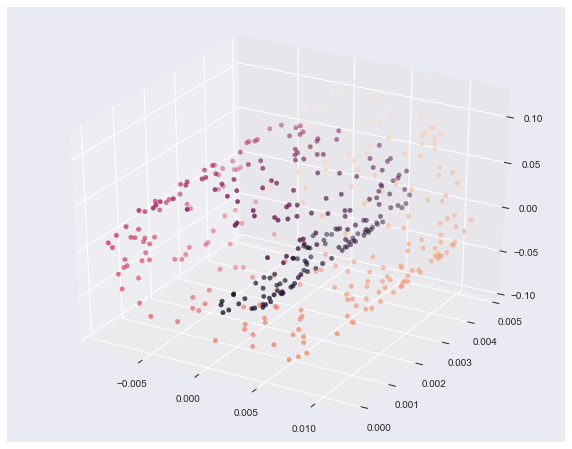

In [3]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x[0,:], x[1,:], x[2,:], c=t_true, marker='o')
plt.show()

# Model

In [4]:
#tinit = np.random.multivariate_normal([0] * Dt * N, np.identity(Dt * N)*.25).reshape((1,N))
tinit = np.random.uniform(-1.5, 1.5, size=Dt * N).reshape((Dt,N))
Cinit = np.random.multivariate_normal([0] * Dt * N * Dy, np.identity(Dt * N * Dy)*0.25).reshape(Dy,Dt*N)

#build nearest neighbor graph
G = neighbors.kneighbors_graph(x.T, 9, mode='connectivity')
G = G + G.T
G.data = np.ones_like(G.data)

#set user-defined parameters
alpha = 1.0
gamma =5.0
epsilon = .00001
#V = np.identity(Dy) * gamma
V = np.cov(x) * gamma

#to initialize from the priors
#degree = np.sum(G,1)
#L = np.diag(degree) - G
#omega_inv = np.kron(2*L, np.identity(Dt))
#Pi_inv = chol_inv(alpha * np.identity(N*Dt) + omega_inv)
#J = np.kron(np.ones(shape=(N,1)),np.identity(Dt))
#C_priorcov = ln.inv(epsilon * J * J.T + omega_inv)
#tinit = np.random.multivariate_normal(np.zeros(Dt*N),Pi_inv).reshape((Dt,N))
#Cinit = np.random.multivariate_normal(np.zeros(shape=(Dy*N*Dt)),np.kron(np.identity(Dy),C_priorcov)).reshape((Dy,Dt*N))


model = LL_LVM(G,epsilon,alpha,V,Cinit,tinit,x,.0005)
#model.likelihood()
#model.propose()
#model.likelihood(proposed=True)

# Sampling

In [5]:
n_burn = 10

for i in range(n_burn):
    print("\rStep %d of %d" % (i+1,n_burn), end="")
    model.MH_step(burn_in=True)

Step 10 of 10

In [6]:
n_samp = 30

for i in range(n_samp):
    print("\rStep %d of %d" % (i+1,n_samp), end="")
    model.MH_step(burn_in=False)

Step 30 of 30

In [7]:
acceptance_rate = model.acceptance / (n_samp+n_burn)
t = model.tfinal / 3000.0

print("Acceptance rate: %.8f" % acceptance_rate)

Acceptance rate: 0.32500000


# Likelihood Plot

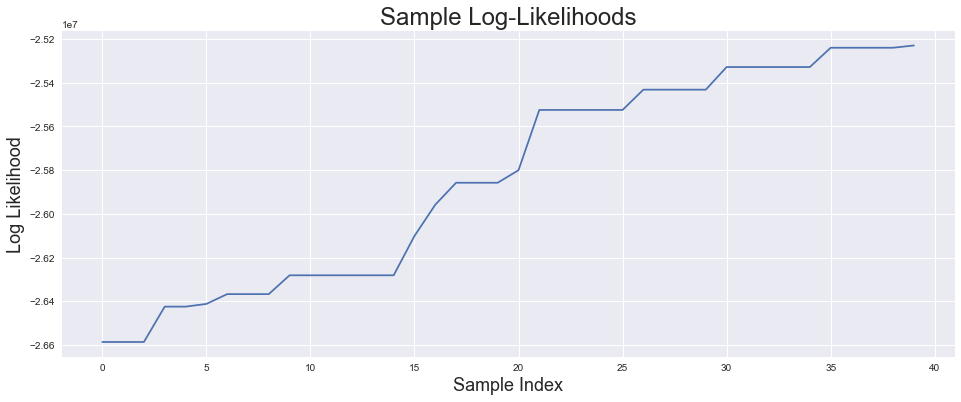

In [8]:
rcParams['figure.figsize'] = (16,6)
plt.plot(model.likelihoods)
plt.title("Sample Log-Likelihoods", fontsize=24)
plt.ylabel("Log Likelihood", fontsize=18)
plt.xlabel("Sample Index", fontsize=18);

## Version Information

In [9]:
%load_ext version_information
%version_information numpy, scipy, sklearn, matplotlib, version_information

Software versions
Python 3.6.2 64bit [GCC 4.2.1 Compatible Apple LLVM 6.1.0 (clang-602.0.53)]
IPython 6.2.1
OS Darwin 15.6.0 x86_64 i386 64bit
numpy 1.13.3
scipy 0.19.1
sklearn 0.19.1
matplotlib 2.1.0
version_information 1.0.3
Wed Nov 08 18:51:08 2017 EST